In [2]:
% load_ext autoreload
% autoreload 2

In [3]:
from wilds.datasets.ogbmolpcba_dataset import OGBPCBADataset
from torch.utils.data import DataLoader
from torch_geometric.loader.dataloader import Collater
from models.gnn import GINVirtual
import torch
from utils.generic import key_replace
import matplotlib.pyplot as plt

In [4]:
d = OGBPCBADataset(root_dir='/voyager/datasets')

In [11]:
dl = DataLoader(d.get_subset('train'), batch_size=1024, shuffle=True,
                collate_fn=Collater(exclude_keys=[], follow_batch=[]))

In [66]:
model = GINVirtual()
sd = torch.load('/voyager/projects/tomginsberg/wilds_models/ogb-molpcba_erm_seed1/best_model.pth')
model.load_state_dict(key_replace(sd['algorithm'], 'model.'))

<All keys matched successfully>

In [8]:
from torchmetrics import Accuracy
from tqdm import tqdm

In [67]:
model.eval()
model = model.to('cuda')
p, l = [], []
for i, batch in enumerate(tqdm(dl)):
    with torch.no_grad():
        pred = model(batch[0].cuda())
        p.append(pred)
        l.append(batch[1])

p = torch.cat(p).cpu()
l = torch.cat(l).cpu()

100%|█████████████████████████████████████████████████████████████████| 343/343 [00:24<00:00, 14.19it/s]


In [51]:
from torchmetrics import Precision, Recall


def scores_with_nan(y_pred, y_true):
    mask = ~torch.isnan(y_true)
    y_true = y_true[mask].int()
    y_pred = torch.sigmoid(y_pred[mask])
    scores = [Precision(), Recall()]
    [s.update(y_pred, y_true) for s in scores]
    return torch.stack([s.compute() for s in scores])

In [69]:
scores = torch.stack([scores_with_nan(p[:, i], l[:, i]) for i in range(p.shape[1])])

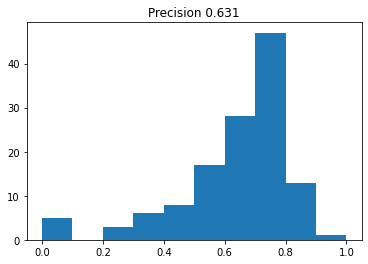

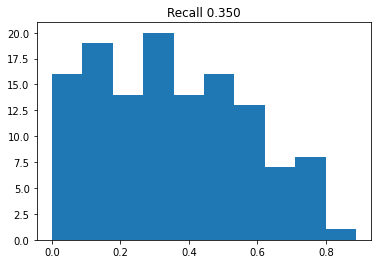

In [70]:
plt.hist(scores[:,0].numpy())
plt.title(f'Precision {scores[:,0].mean().item():.3f}')
plt.show()
plt.hist(scores[:,1].numpy())
plt.title(f'Recall {scores[:,1].mean().item():.3f}');

1